In [1]:
from qiskit.qasm import Qasm
from qiskit.qasm.node import *

def gen_qasm(self):
    if isinstance(self, Barrier):
        return "barrier " + gen_qasm(self.children[0]) + ";"
    elif isinstance(self, BinaryOp):
        return (
            "(" + gen_qasm(self.children[1]) + self.children[0].value + gen_qasm(self.children[2]) + ")"
        )
    elif isinstance(self, BinaryOperator):
        return self.value
    elif isinstance(self, Cnot):
        return "CX " + gen_qasm(self.children[0]) + "," + gen_qasm(self.children[1]) + ";"
    elif isinstance(self, Creg):
        return "creg " + gen_qasm(self.id) + ";"
    elif isinstance(self, CustomUnitary):
        string = self.name
        if self.arguments is not None:
            string += "(" + gen_qasm(self.arguments) + ")"
        string += " " + gen_qasm(self.bitlist) + ";"
        return string
    elif isinstance(self, ExpressionList):
        return ",".join([gen_qasm(self.children[j]) for j in range(self.size())])
    elif isinstance(self, External):
        return gen_qasm(self.children[0]) + "(" + gen_qasm(self.children[1]) + ")"
    elif isinstance(self, Format):
        return f"{self.language} {self.version()};"
    elif isinstance(self, Gate):
        string = "gate " + self.name
        if self.arguments is not None:
            string += "(" + gen_qasm(self.arguments) + ")"
        string += " " + gen_qasm(self.bitlist) + "\n"
        string += "{\n" + gen_qasm(self.body) + "}"
        return string
    elif isinstance(self, GateBody):
        string = ""
        for children in self.children:
            string += "  " + gen_qasm(children) + "\n"
        return string
    elif isinstance(self, Id):
        return self.name
    elif isinstance(self, IdList):
        return ",".join([gen_qasm(self.children[j]) for j in range(self.size())])
    elif isinstance(self, If):
        return (
            "if("
            + gen_qasm(self.children[0])
            + "=="
            + str(self.children[1].value)
            + ") "
            + gen_qasm(self.children[2])
        )
    elif isinstance(self, IndexedId):
        return self.name + "[%d]" % self.index
    elif isinstance(self, Int):
        return "%d" % self.value
    elif isinstance(self, Measure):
        return "measure " + gen_qasm(self.children[0]) + " -> " + gen_qasm(self.children[1]) + ";"
    elif isinstance(self, Opaque):
        string = "opaque %s" % self.name
        if self.arguments is not None:
            string += "(" + gen_qasm(self.arguments) + ")"
        string += " " + gen_qasm(self.bitlist) + ";"
        return string
    elif isinstance(self, Prefix):
        return self.children[0].value + "(" + gen_qasm(self.children[1]) + ")"
    elif isinstance(self, PrimaryList):
        return ",".join([gen_qasm(self.children[j]) for j in range(self.size())])
    elif isinstance(self, Program):
        string = ""
        for children in self.children:
            string += gen_qasm(children) + "\n"
        return string
    elif isinstance(self, Qreg):
        return "qreg " + gen_qasm(self.id) + ";"
    elif isinstance(self, Real):
        return str(float(self.value))
    elif isinstance(self, Reset):
        return "reset " + gen_qasm(self.children[0]) + ";"
    elif isinstance(self, UnaryOperator):
        return self.value
    elif isinstance(self, UniversalUnitary):
        return "U(" + gen_qasm(self.children[0]) + ") " + gen_qasm(self.children[1]) + ";"


from qiskit.qasm import Qasm
from qiskit.qasm.node import *

# Hack to remove 'include "qelib1.inc"' gates
# modifies the original programNode
def remove_qelib_inc(programNode):
    del programNode.children[1:43]
    return programNode

def readd_include(qasmCode):
    return qasmCode.replace("OPENQASM 2.0;", "OPENQASM 2.0; include \"qelib1.inc\";")

def renameTransformation(programNode):
    programNode = remove_qelib_inc(programNode)
    
    def uniqueIds(node):
        idsFound = []
        for child in node.children:
            if isinstance(child, Creg) or isinstance(child, Qreg):
                indexedIdNode = child.children[0]
                idNode = indexedIdNode.children[0]
                idsFound += [idNode.name]
            else:
                idsFound += uniqueIds(child)
        return idsFound

    # mapping : srcName -> destName
    def renames(node, mapping):
        for child in node.children:
            if isinstance(child, Id):
                if child.name in mapping:
                    child.name = mapping[child.name]
            # indexed id has its own name field,
            # which messes with the generation of IndexedId
            elif isinstance(child, IndexedId): 
                if child.name in mapping:
                    child.name = mapping[child.name]
                renames(child, mapping)
            else:
                renames(child, mapping)
        
    ids = uniqueIds(programNode)
    mapping = {}
    for i in range(1, len(ids), 2):
        mapping[ids[i]] = ids[i-1]
        mapping[ids[i-1]] = ids[i]
    
    renames(programNode, mapping)
    return programNode

# may break on custom gates (Gate, Opaque, GateBody)
def swapTransformation(programNode):
    programNode = remove_qelib_inc(programNode)

    independent_sets = []
    current_independent = []

    def get_children_ids(node):
        ids = [] # coded in str (c, -1) for all, (c, 0) for int
        if isinstance(node, IndexedId):
            idName = node.children[0].name
            intNum = node.children[1].value
            ids.append((idName, intNum))
            return ids
        elif isinstance(node, Id):
            idName = node.name
            intNum = -1
            ids.append((idName, intNum))
            return ids
        for child in node.children:
            if isinstance(child, IndexedId):
                idName = child.children[0].name
                intNum = child.children[1].value
                ids.append((idName, intNum))
            elif isinstance(child, Id):
                idName = child.name
                intNum = -1
                ids.append((idName, intNum))
            else:
                ids += get_children_ids(child)
        return ids
    
    def handle_dependence(node):
        nonlocal current_independent
        if isinstance(node, CustomUnitary): #quickfix
            if len(node.children) == 3:
                ids = get_children_ids(node.children[2])
            else:
                ids = get_children_ids(node.children[1])
        else:
            ids = get_children_ids(node)
        new_part = (node, ids)
        is_dependent = False
        for cur_node in current_independent:
            for new_id in ids:
                for cur_id in cur_node[1]:
                    if (new_id[1] == -1 and cur_id[0] == new_id[0]) or new_id == cur_id:
                        is_dependent = True
        if(is_dependent):
            independent_sets.append(current_independent)
            current_independent = [new_part]
        else:
            current_independent.append(new_part)

    for child in programNode.children:
        if isinstance(child, Barrier):
            independent_sets += [current_independent, [(child, ())]]
            current_independent = []
        elif isinstance(child, Cnot):
            handle_dependence(child)
        elif isinstance(child, Creg): #TODO
            independent_sets += [current_independent, [(child, ())]]
            current_independent = []
        elif isinstance(child, CustomUnitary):
            handle_dependence(child)
        # elif isinstance(child, External):
        #     handle_dependence(child)
        elif isinstance(child, If): # unsure of scope here (are you able to define a qreg/creg in a body?)
            handle_dependence(child)
        elif isinstance(child, Measure):
            independent_sets += [current_independent, [(child, ())]]
            current_independent = []
        elif isinstance(child, Qreg):
            independent_sets += [current_independent, [(child, ())]]
            current_independent = []
        elif isinstance(child, Reset): # handle id and indexed_id
            handle_dependence(child)
        elif isinstance(child, UniversalUnitary): # handle id and indexed_id
            handle_dependence(child)
        elif isinstance(child, Format):
            independent_sets += [current_independent, [(child, [()])]]
            current_independent = []
        elif isinstance(child, Gate):
            independent_sets += [current_independent, [(child, [()])]]
            current_independent = []
        else: # Throw Error - will error out custom gates
            print("ERROR: ", child)
    
    independent_sets += [current_independent]
    
    new_children = []
    for op_list in independent_sets:
        new_children.extend([i[0] for i in reversed(op_list)])
    new_program = Program(new_children)
        
    return new_program

def prettyfy(str: str):
    return str.replace("\n", " ")

def applyTransformations(str):
    ast = Qasm(data=str).parse()
    return readd_include(prettyfy(gen_qasm(swapTransformation(ast))))

In [2]:
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer, TFBertModel, TFDistilBertForMultipleChoice
from transformers import TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFGPT2ForSequenceClassification, TFRobertaForSequenceClassification

import json

MODEL_NAME = 'distilbert-base-uncased'
MODEL_NAME = 'huggingface/CodeBERTa-small-v1'
BATCH_SIZE = 4
N_EPOCHS = 3

c:\Users\janko\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
task_x = []
task_y = []
task_test_x = []
task_test_y = []

with open("../dataset/train_x.txt", 'r') as f:
  for line in f:
    task_x.append(line)


with open("../dataset/train_y.txt", 'r') as f:
  for line in f:
    task_y.append(line)


with open("../dataset/test_x.txt", 'r') as f:
  for line in f:
    task_test_x.append(line)


with open("../dataset/test_y.txt", 'r') as f:
  for line in f:
    task_test_y.append(line)

# halve the dataset
task_x = task_x[0:int(len(task_x)/2)]
task_y = task_y[0:int(len(task_y)/2)]
task_test_x = task_test_x[0:int(len(task_test_x)/2)]
task_test_y = task_test_y[0:int(len(task_test_y)/2)]

# augument data
def augumented(lineList):
  return [applyTransformations(l) for l in lineList]

task_x_a = task_x #+ augumented(task_x)
task_y_a = task_y #+ task_y
task_test_x_a = task_test_x #+ augumented(task_test_x)
task_test_y_a = task_test_y #+ task_test_y

print(len(task_x), len(task_y),len(task_test_x),len(task_test_y))
print(len(task_x_a), len(task_y_a),len(task_test_x_a),len(task_test_y_a))

8990 8990 999 999
8990 8990 1998 1998


In [15]:
x = task_x_a
y = task_y_a
test_x = task_test_x_a
test_y = task_test_y_a

model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# tokenize the text
train_encodings = tokenizer(list(x),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizer(list(test_x),
                           truncation=True, 
                           padding=True)

y_str = []
test_y_str = []

for a in y:
  y_str.append(int(a))

for a in test_y:
  test_y_str.append(int(a))


train_dataset2 = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                    list(y_str)))
test_dataset2 = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                    list(test_y_str)))
 
# chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)

# define the loss function 
losss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizerr,
              loss=losss2,
              metrics=['accuracy'])

# train the model 
history = model.fit(train_dataset2.shuffle(len(x)).batch(BATCH_SIZE),epochs=5, batch_size=BATCH_SIZE)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
4495/4495 [==============================] - 1697s 375ms/step - loss: 0.6747 - accuracy: 0.7232
Epoch 2/5
4495/4495 [==============================] - 1676s 373ms/step - loss: 0.6366 - accuracy: 0.7344
Epoch 3/5
4495/4495 [==============================] - 1670s 372ms/step - loss: 0.6224 - accuracy: 0.7392
Epoch 4/5
4495/4495 [==============================] - 1674s 372ms/step - loss: 0.6161 - accuracy: 0.7380
Epoch 5/5
4495/4495 [==============================] - 1672s 372ms/step - loss: 0.6514 - accuracy: 0.7250


              precision    recall  f1-score   support

           0       0.95      0.48      0.64       398
           1       0.72      0.99      0.84      1306
           2       0.60      0.01      0.02       294

    accuracy                           0.75      1998
   macro avg       0.76      0.49      0.50      1998
weighted avg       0.75      0.75      0.68      1998

0.7462462462462462


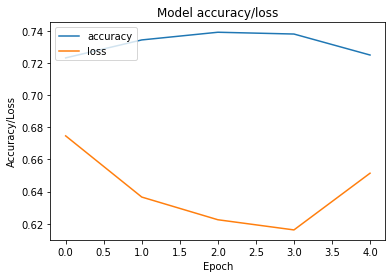

In [18]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

predictions1_tran = []

test = model.predict(test_dataset2.batch(1)).logits
for a in test:
  predictions1_tran.append(int(np.argmax(tf.nn.softmax(a, axis=0).numpy())))

print(classification_report(test_y_str, predictions1_tran))
print(accuracy_score(test_y_str, predictions1_tran))

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy/loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

x = task_x
y = task_y
test_x = task_test_x_a
test_y = task_test_y_a

model2 = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# tokenize the text
train_encodings = tokenizer(list(x),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizer(list(test_x),
                           truncation=True, 
                           padding=True)

y_str = []
test_y_str = []

for a in y:
  y_str.append(int(a))

for a in test_y:
  test_y_str.append(int(a))


train_dataset2 = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                    list(y_str)))
test_dataset2 = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                    list(test_y_str)))
 
# chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)

# define the loss function 
losss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model2.compile(optimizer=optimizerr,
              loss=losss2,
              metrics=['accuracy'])

# train the model 
history2 = model2.fit(train_dataset2.shuffle(len(x)).batch(BATCH_SIZE),epochs=5, batch_size=BATCH_SIZE)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
2248/2248 [==============================] - 845s 371ms/step - loss: 0.6884 - accuracy: 0.7216
Epoch 2/5
2248/2248 [==============================] - 841s 374ms/step - loss: 0.6466 - accuracy: 0.7274
Epoch 3/5
2248/2248 [==============================] - 841s 374ms/step - loss: 0.6255 - accuracy: 0.7349
Epoch 4/5
2248/2248 [==============================] - 840s 374ms/step - loss: 0.6150 - accuracy: 0.7404
Epoch 5/5
2248/2248 [==============================] - 840s 374ms/step - loss: 0.5875 - accuracy: 0.7525


              precision    recall  f1-score   support

           0       0.59      0.69      0.64       398
           1       0.86      0.74      0.80      1306
           2       0.32      0.44      0.37       294

    accuracy                           0.69      1998
   macro avg       0.59      0.62      0.60      1998
weighted avg       0.73      0.69      0.70      1998

0.6886886886886887


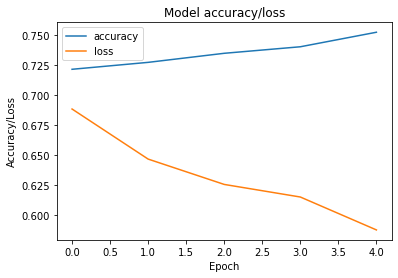

In [5]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

predictions1_tran = []

test = model2.predict(test_dataset2.batch(1)).logits
for a in test:
  predictions1_tran.append(int(np.argmax(tf.nn.softmax(a, axis=0).numpy())))

print(classification_report(test_y_str, predictions1_tran))
print(accuracy_score(test_y_str, predictions1_tran))

import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['loss'])
plt.title('Model accuracy/loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()